In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
import time

2.10.0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import sys, os
from pathlib import Path
import glob

import PIL
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model

from keras.utils import to_categorical

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import itertools
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import callbacks


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
print(f'Tensorflow: {tf.__version__}')
gpu_count = sum(1 for dev in tf.config.experimental.list_physical_devices()
                    if dev.device_type == 'GPU')
print(f'Number of GPUs: {gpu_count}')

Tensorflow: 2.10.0
Number of GPUs: 1


In [4]:
root_path = 'C:/Users/amara/Documents/Formation_DS_DataScientest/Projet_DS_DataScientest_BCC/Blood_Cells_Classification'

#root_path = '/content/drive/MyDrive/Projet_DS_DataScientest_BCC'
data_path = f'{root_path}/2-Data'

In [5]:
img_df = pd.read_csv(f'{data_path}/BCC_dataset_fin_woOutliers.csv')

C:\Users\amara\AppData\Local\Temp\ipykernel_67000\3660797764.py:1: DtypeWarning: Columns (12,13,14,15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  img_df = pd.read_csv(f'{data_path}/BCC_dataset_fin_woOutliers.csv')


In [6]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67616 entries, 0 to 67615
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   img_id               67616 non-null  object 
 1   blood_cell_original  67616 non-null  object 
 2   image_path           67616 non-null  object 
 3   source               67616 non-null  object 
 4   extension            67616 non-null  object 
 5   height               67616 non-null  int64  
 6   width                67616 non-null  int64  
 7   channels             67616 non-null  int64  
 8   depth                67616 non-null  object 
 9   mean_luminance       67616 non-null  float64
 10  std_luminance        67616 non-null  float64
 11  bad_class            32796 non-null  float64
 12  subsource            16480 non-null  object 
 13  Patient_ID           15704 non-null  object 
 14  slide_type           15704 non-null  object 
 15  Diagnosis            15704 non-null 

## Analyse des jeux de données avec les 12 catégories

In [7]:
# Tableau croisé pour img_df
crosstabl = pd.crosstab(index=img_df['blood_cell'], columns=img_df['source'])
pourcentages = crosstabl.apply(lambda x: 100 * x / float(x.sum()), axis=1)
crosstabl['Total'] = crosstabl.sum(axis=1)
crosstabl['% Total'] = 100 * crosstabl['Total'] / crosstabl['Total'].sum()
for col in crosstabl.columns[:-2]:
    crosstabl[col + ' %'] = 100 * crosstabl[col] / crosstabl['Total']
print(crosstabl)

source      Barcelona  Kaggle  Munich  Raabin  Total    % Total  Barcelona %  \
blood_cell                                                                     
ART                 0    2992      15       0   3007   4.447172     0.000000   
BAS              1218      53      79     289   1639   2.423982    74.313606   
EOS              3117     108     422    1063   4710   6.965807    66.178344   
ERY              1551     526      78       0   2155   3.187115    71.972158   
IG                151       0       0       0    151   0.223320   100.000000   
LYM              1214    3998    3947    3585  12744  18.847610     9.526051   
MMC              1015      75      15       0   1105   1.634229    91.855204   
MON              1420    1385    1814     792   5411   8.002544    26.242839   
MYB                 0    3327    3253       0   6580   9.731425     0.000000   
MYC              1137     181      42       0   1360   2.011358    83.602941   
NEU              3329    2305    8587   

### Graphiques de répartition des classes de PBC

##### 1. Répartition des cellules sanguines toutes sources confondues

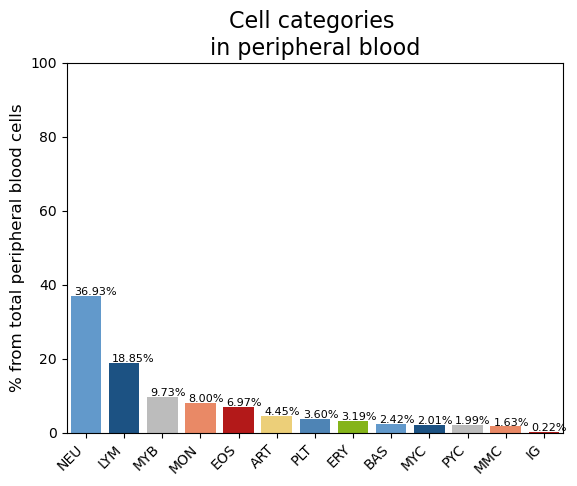

In [8]:
### Barplot : Cell categories for the whole dataset (wo images outliers)
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = img_df['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.sort_values(ascending=False)

sns.barplot(x=df_temp.index, y=df_temp.values, palette= colors)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.ylabel('% from total peripheral blood cells', fontsize =12)
plt.title("Cell categories \nin peripheral blood", fontsize= 16)
for i in range(len(df_temp)):
    plt.text(x = i-0.32, y = df_temp.values[i]+0.2, s = f"{df_temp.values[i]:.2f}%", size = 8)

plt.savefig("barplot_cells_wo_12cat.png", dpi=300, bbox_inches='tight')

##### 2. Répartition des cellules sanguines suvant les sources de données

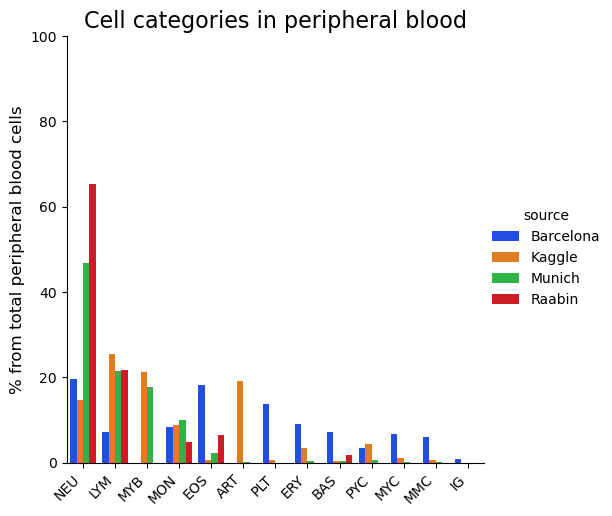

In [13]:
### Barplot : Cell categories for the whole dataset (wo images outliers) by source of data
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = img_df.groupby('source')['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.reset_index(name='%')

order = ['NEU', 'LYM', 'MYB', 'MON', 'EOS', 'ART', 'PLT', 'ERY', 'BAS', 'PYC', 'MYC', 'MMC', 'IG']
sns.catplot(x='blood_cell', y='%', hue='source', data=df_temp, kind='bar', palette='bright', order=order)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.xlabel('')
#plt.legend(loc='upper right',)
plt.ylabel('% from total peripheral blood cells', fontsize=12)
plt.title("Cell categories in peripheral blood", fontsize=16)
plt.savefig("barplot_cells_wo_12cat_bysource.png", dpi=300, bbox_inches='tight')

### Division du jeu de données en "Train", "Validation" et "Test"

In [14]:
# Diviser les données en jeu de données d'entraînement et de test
train_data, test_data = train_test_split(img_df, test_size=0.2, random_state=42, stratify=img_df['blood_cell'])

# Diviser le jeu de données d'entraînement en jeu de données d'entraînement et de validation
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['blood_cell'])

# Enregistrer les données dans des fichiers CSV séparés
train_data.to_csv(f'{data_path}/BCC_train_data_strat.csv', index=False)
validation_data.to_csv(f'{data_path}/BCC_val_data_strat.csv', index=False)
test_data.to_csv(f'{data_path}/BCC_test_data_strat.csv', index=False)

In [157]:
#train_data = pd.read_csv(f'{data_path}/BCC_train_data_strat.csv')
#validation_data = pd.read_csv(f'{data_path}/BCC_val_data_strat.csv')
#test_data = pd.read_csv(f'{data_path}/BCC_test_data_strat.csv')

#### 1. Répartition des cellules sanguines du jeu de données d'entraînement

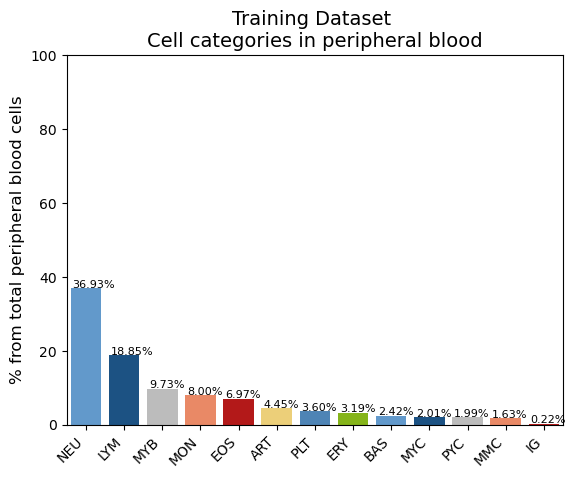

In [15]:
### Barplot : Cell categories for the train dataset (wo images outliers)
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = train_data['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.sort_values(ascending=False)
sns.barplot(x=df_temp.index, y=df_temp.values, palette= colors)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.ylabel('% from total peripheral blood cells', fontsize =12)
plt.title("Training Dataset \nCell categories in peripheral blood", fontsize= 14)
for i in range(len(df_temp)):
    plt.text(x = i-0.35, y = df_temp.values[i]+0.2, s = f"{df_temp.values[i]:.2f}%", size = 8)

plt.savefig("barplot_cells_wo_13cat_training.png", dpi=300, bbox_inches='tight')

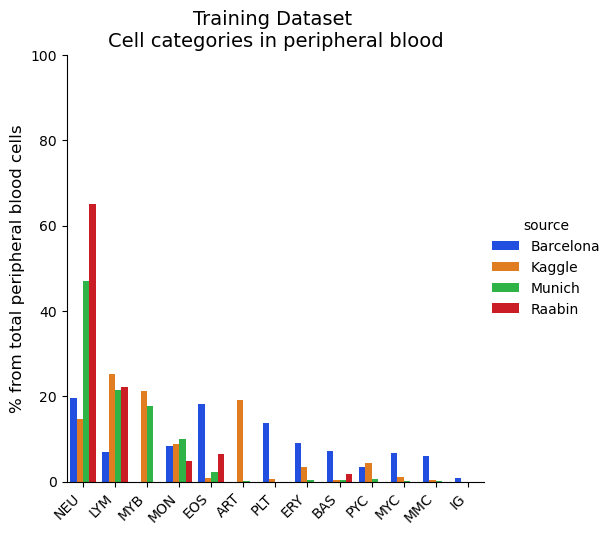

In [16]:
### Barplot : Cell categories for the whole dataset (wo images outliers) by training/val/test data
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = train_data.groupby('source')['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.reset_index(name='%')

order = ['NEU', 'LYM', 'MYB', 'MON', 'EOS', 'ART', 'PLT', 'ERY', 'BAS', 'PYC', 'MYC', 'MMC', 'IG']
sns.catplot(x='blood_cell', y='%', hue='source', data=df_temp, kind='bar', palette='bright', order=order)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.xlabel('')
#plt.legend(loc='upper right',)
plt.ylabel('% from total peripheral blood cells', fontsize=12)
plt.title("Training Dataset \nCell categories in peripheral blood", fontsize=14)
plt.savefig("barplot_cells_wo_12cat_bysource_train.png", dpi=300, bbox_inches='tight')

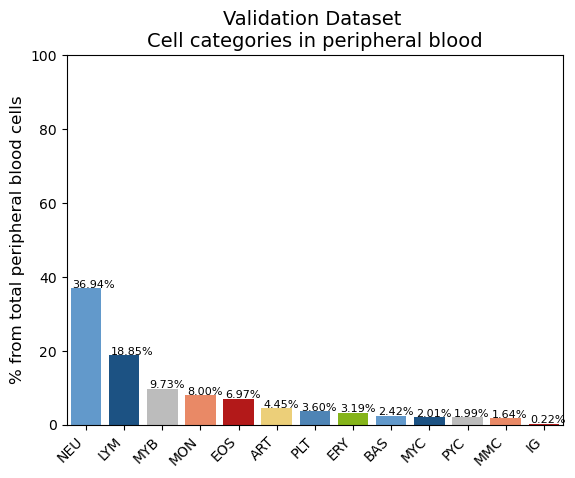

In [17]:
### Barplot : Cell categories for validation dataset (wo images outliers)
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = validation_data['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.sort_values(ascending=False)
sns.barplot(x=df_temp.index, y=df_temp.values, palette= colors)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.ylabel('% from total peripheral blood cells', fontsize =12)
plt.title("Validation Dataset \nCell categories in peripheral blood", fontsize= 14)
for i in range(len(df_temp)):
    plt.text(x = i-0.35, y = df_temp.values[i]+0.2, s = f"{df_temp.values[i]:.2f}%", size = 8)

plt.savefig("barplot_cells_wo_13cat_valid.png", dpi=300, bbox_inches='tight')

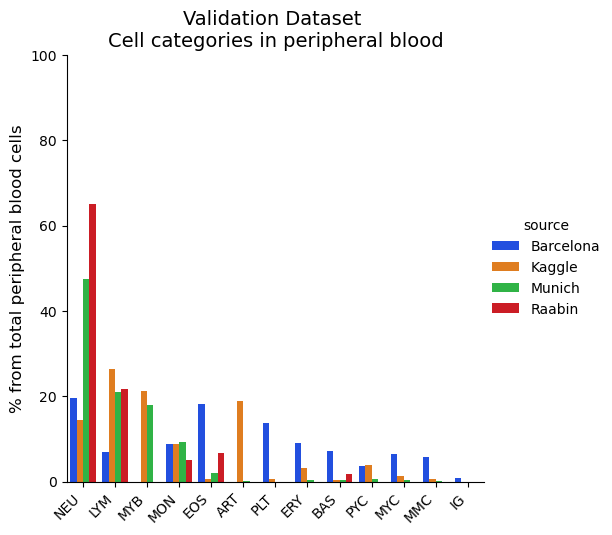

In [19]:
### Barplot : Cell categories for the whole dataset (wo images outliers) by training/val/test data
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = validation_data.groupby('source')['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.reset_index(name='%')

order = ['NEU', 'LYM', 'MYB', 'MON', 'EOS', 'ART', 'PLT', 'ERY', 'BAS', 'PYC', 'MYC', 'MMC', 'IG']
sns.catplot(x='blood_cell', y='%', hue='source', data=df_temp, kind='bar', palette='bright', order=order)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.xlabel('')
#plt.legend(loc='upper right',)
plt.ylabel('% from total peripheral blood cells', fontsize=12)
plt.title("Validation Dataset \nCell categories in peripheral blood", fontsize=14)
plt.savefig("barplot_cells_wo_13cat_bysource_valid.png", dpi=300, bbox_inches='tight')

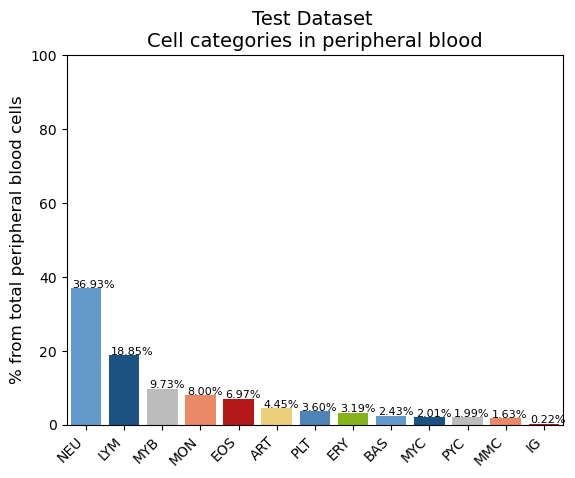

In [20]:
### Barplot : Cell categories for test dataset (wo images outliers)
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = test_data['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.sort_values(ascending=False)
sns.barplot(x=df_temp.index, y=df_temp.values, palette= colors)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.ylabel('% from total peripheral blood cells', fontsize =12)
plt.title("Test Dataset \nCell categories in peripheral blood", fontsize= 14)
for i in range(len(df_temp)):
    plt.text(x = i-0.35, y = df_temp.values[i]+0.2, s = f"{df_temp.values[i]:.2f}%", size = 8)

plt.savefig("barplot_cells_wo_13cat_test.png", dpi=300, bbox_inches='tight')

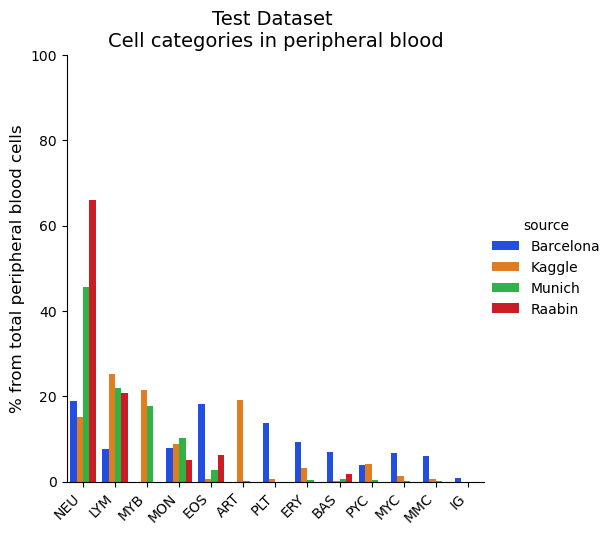

In [21]:
### Barplot : Cell categories for the whole dataset (wo images outliers) by training/val/test data
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = test_data.groupby('source')['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.reset_index(name='%')

order = ['NEU', 'LYM', 'MYB', 'MON', 'EOS', 'ART', 'PLT', 'ERY', 'BAS', 'PYC', 'MYC', 'MMC', 'IG']
sns.catplot(x='blood_cell', y='%', hue='source', data=df_temp, kind='bar', palette='bright', order=order)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.xlabel('')
#plt.legend(loc='upper right',)
plt.ylabel('% from total peripheral blood cells', fontsize=12)
plt.title("Test Dataset \nCell categories in peripheral blood", fontsize=14)
plt.savefig("barplot_cells_wo_13cat_bysource_test.png", dpi=300, bbox_inches='tight')

## Analyse des jeux de données avec 10 catégories

### Regroupement des classes IG, MMY, PYC et MYC en une classe IG 

In [22]:
# Remplacer les valeurs MMC, MYC et PYC par IG dans la colonne "blood_cell"
img_df['blood_cell'] = img_df['blood_cell'].replace(['IG', 'MMC', 'MYC', 'PYC'], 'IG')
#img_df = img_df[img_df['blood_cell'] != 'ART']
img_df.head()

,img_id,blood_cell_original,image_path,source,extension,height,width,channels,depth,mean_luminance,...,Patient_ID,slide_type,Diagnosis,Cohort,Age at Diagnosis,Gender,cell_category,blood_cell,brightness,luminance
0,BA_100102,Basophil,C:/Users/amara/Documents/Formation_DS_DataScie...,Barcelona,.jpg,363,360,3,uint8,201.010843,...,NaN,NaN,NaN,NaN,NaN,NaN,basophil,BAS,227.090579,201.009514
1,BA_101381,Basophil,C:/Users/amara/Documents/Formation_DS_DataScie...,Barcelona,.jpg,363,360,3,uint8,194.197834,...,NaN,NaN,NaN,NaN,NaN,NaN,basophil,BAS,221.648225,194.196219
2,BA_101611,Basophil,C:/Users/amara/Documents/Formation_DS_DataScie...,Barcelona,.jpg,363,360,3,uint8,193.350826,...,NaN,NaN,NaN,NaN,NaN,NaN,basophil,BAS,222.109144,193.343202
3,BA_102039,Basophil,C:/Users/amara/Documents/Formation_DS_DataScie...,Barcelona,.jpg,363,360,3,uint8,188.760063,...,NaN,NaN,NaN,NaN,NaN,NaN,basophil,BAS,217.042068,188.754761
4,BA_102750,Basophil,C:/Users/amara/Documents/Formation_DS_DataScie...,Barcelona,.jpg,363,360,3,uint8,203.143595,...,NaN,NaN,NaN,NaN,NaN,NaN,basophil,BAS,229.331057,203.136620


In [23]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67616 entries, 0 to 67615
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   img_id               67616 non-null  object 
 1   blood_cell_original  67616 non-null  object 
 2   image_path           67616 non-null  object 
 3   source               67616 non-null  object 
 4   extension            67616 non-null  object 
 5   height               67616 non-null  int64  
 6   width                67616 non-null  int64  
 7   channels             67616 non-null  int64  
 8   depth                67616 non-null  object 
 9   mean_luminance       67616 non-null  float64
 10  std_luminance        67616 non-null  float64
 11  bad_class            32796 non-null  float64
 12  subsource            16480 non-null  object 
 13  Patient_ID           15704 non-null  object 
 14  slide_type           15704 non-null  object 
 15  Diagnosis            15704 non-null 

In [24]:
# Tableau croisé pour train
crosstabl = pd.crosstab(index=img_df['blood_cell'], columns=img_df['source'])
pourcentages = crosstabl.apply(lambda x: 100 * x / float(x.sum()), axis=1)
crosstabl['Total'] = crosstabl.sum(axis=1)
crosstabl['% Total'] = 100 * crosstabl['Total'] / crosstabl['Total'].sum()
for col in crosstabl.columns[:-2]:
    crosstabl[col + ' %'] = 100 * crosstabl[col] / crosstabl['Total']
print(crosstabl)

source      Barcelona  Kaggle  Munich  Raabin  Total    % Total  Barcelona %  \
blood_cell                                                                     
ART                 0    2992      15       0   3007   4.447172     0.000000   
BAS              1218      53      79     289   1639   2.423982    74.313606   
EOS              3117     108     422    1063   4710   6.965807    66.178344   
ERY              1551     526      78       0   2155   3.187115    71.972158   
IG               2895     922     145       0   3962   5.859560    73.069157   
LYM              1214    3998    3947    3585  12744  18.847610     9.526051   
MON              1420    1385    1814     792   5411   8.002544    26.242839   
MYB                 0    3327    3253       0   6580   9.731425     0.000000   
NEU              3329    2305    8587   10751  24972  36.932087    13.330931   
PLT              2348      88       0       0   2436   3.602698    96.387521   

source       Kaggle %   Munich %   Raab

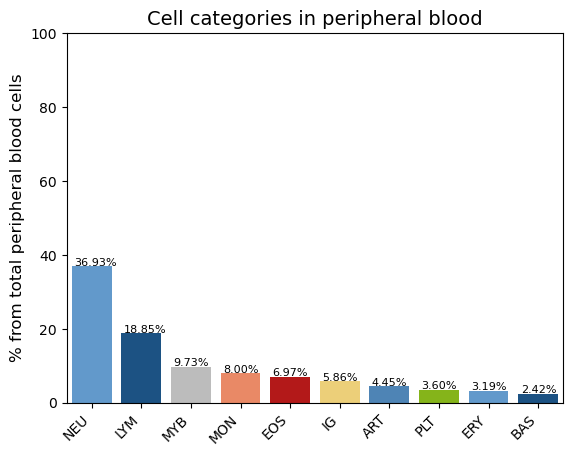

In [25]:
### Barplot : Cell categories for test dataset (wo images outliers)
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = img_df['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.sort_values(ascending=False)
sns.barplot(x=df_temp.index, y=df_temp.values, palette= colors)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.ylabel('% from total peripheral blood cells', fontsize =12)
plt.title("Cell categories in peripheral blood", fontsize= 14)
for i in range(len(df_temp)):
    plt.text(x = i-0.35, y = df_temp.values[i]+0.2, s = f"{df_temp.values[i]:.2f}%", size = 8)

plt.savefig("barplot_cells_wo_10cat.png", dpi=300, bbox_inches='tight')

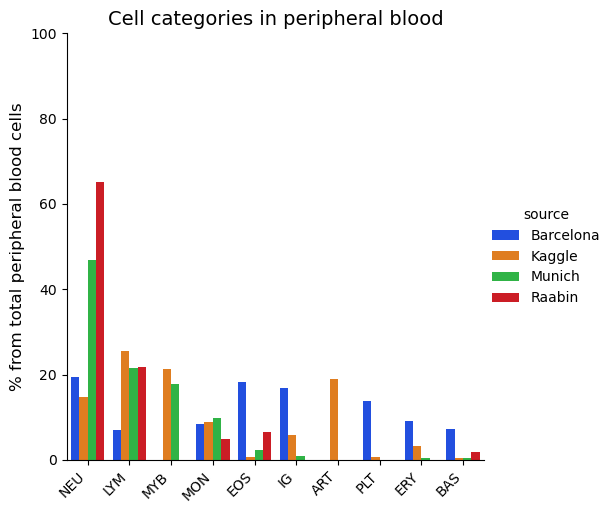

In [41]:
### Barplot : Cell categories for the whole dataset (wo images outliers) by training/val/test data
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = img_df.groupby('source')['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.reset_index(name='%')

order = ['NEU', 'LYM', 'MYB', 'MON', 'EOS', 'IG', 'ART', 'PLT', 'ERY', 'BAS']
sns.catplot(x='blood_cell', y='%', hue='source', data=df_temp, kind='bar', palette='bright', order=order)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.xlabel('')
#plt.legend(loc='upper right',)
plt.ylabel('% from total peripheral blood cells', fontsize=12)
plt.title("Cell categories in peripheral blood", fontsize=14)
plt.savefig("barplot_cells_wo_10cat_bysource.png", dpi=300, bbox_inches='tight')

### Division du jeu de données en "Train", "Validation" et "Test"

In [28]:
# Diviser les données en jeu de données d'entraînement et de test
train_data, test_data = train_test_split(img_df, test_size=0.2, random_state=42, stratify=img_df['blood_cell'])

# Diviser le jeu de données d'entraînement en jeu de données d'entraînement et de validation
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['blood_cell'])

# Enregistrer les données dans des fichiers CSV séparés
train_data.to_csv(f'{data_path}/BCC_train_data_strat_ig.csv', index=False)
validation_data.to_csv(f'{data_path}/BCC_val_data_strat_ig.csv', index=False)
test_data.to_csv(f'{data_path}/BCC_test_data_strat_ig.csv', index=False)

In [ ]:
#train_data = pd.read_csv(f'{data_path}/BCC_train_data_strat_ig.csv')
#validation_data = pd.read_csv(f'{data_path}/BCC_val_data_strat_ig.csv')
#test_data = pd.read_csv(f'{data_path}/BCC_test_data_strat_ig.csv')

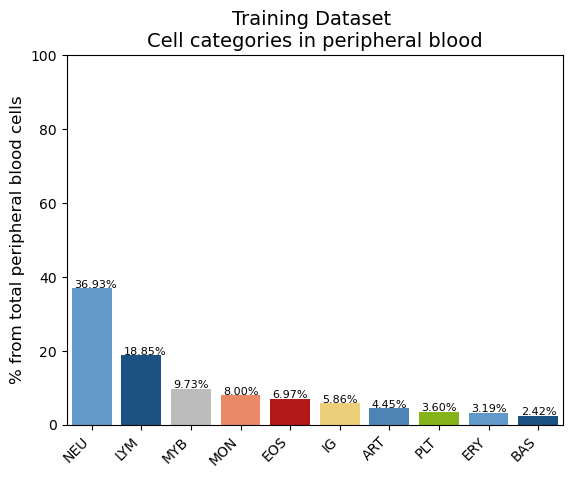

In [29]:
### Barplot : Cell categories for test dataset (wo images outliers)
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = train_data['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.sort_values(ascending=False)
sns.barplot(x=df_temp.index, y=df_temp.values, palette= colors)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.ylabel('% from total peripheral blood cells', fontsize =12)
plt.title("Training Dataset \nCell categories in peripheral blood", fontsize= 14)
for i in range(len(df_temp)):
    plt.text(x = i-0.35, y = df_temp.values[i]+0.2, s = f"{df_temp.values[i]:.2f}%", size = 8)

plt.savefig("barplot_cells_wo_10cat_training.png", dpi=300, bbox_inches='tight')

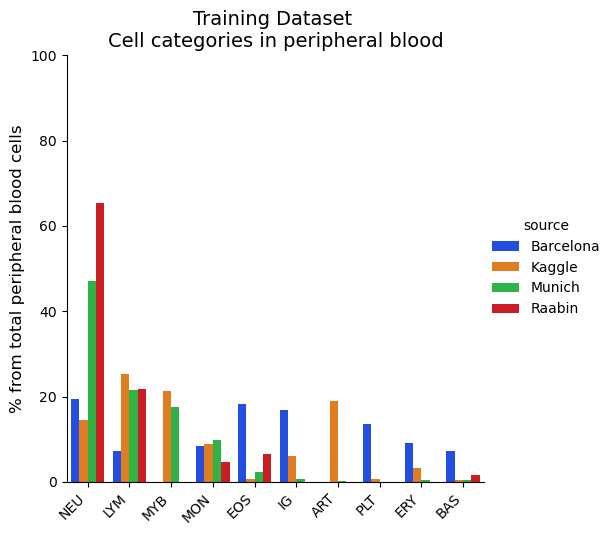

In [31]:
### Barplot : Cell categories for the whole dataset (wo images outliers) by training/val/test data
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = train_data.groupby('source')['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.reset_index(name='%')

order = ['NEU', 'LYM', 'MYB', 'MON', 'EOS', 'IG', 'ART', 'PLT', 'ERY', 'BAS']
sns.catplot(x='blood_cell', y='%', hue='source', data=df_temp, kind='bar', palette='bright', order=order)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.xlabel('')
#plt.legend(loc='upper right',)
plt.ylabel('% from total peripheral blood cells', fontsize=12)
plt.title("Training Dataset \nCell categories in peripheral blood", fontsize=14)
plt.savefig("barplot_cells_wo_10cat_bysource_train.png", dpi=300, bbox_inches='tight')

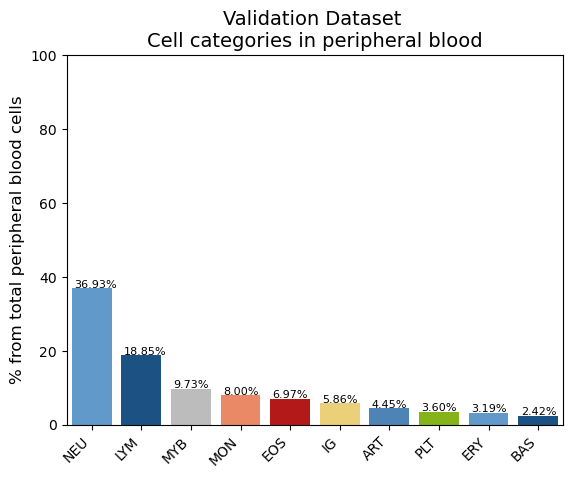

In [32]:
### Barplot : Cell categories for test dataset (wo images outliers)
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = validation_data['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.sort_values(ascending=False)
sns.barplot(x=df_temp.index, y=df_temp.values, palette= colors)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.ylabel('% from total peripheral blood cells', fontsize =12)
plt.title("Validation Dataset \nCell categories in peripheral blood", fontsize= 14)
for i in range(len(df_temp)):
    plt.text(x = i-0.35, y = df_temp.values[i]+0.2, s = f"{df_temp.values[i]:.2f}%", size = 8)

plt.savefig("barplot_cells_wo_10cat_validation.png", dpi=300, bbox_inches='tight')

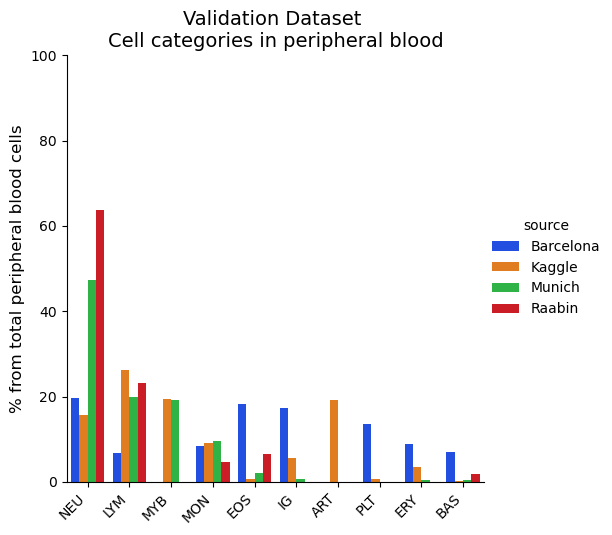

In [33]:
### Barplot : Cell categories for the whole dataset (wo images outliers) by training/val/test data
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = validation_data.groupby('source')['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.reset_index(name='%')

order = ['NEU', 'LYM', 'MYB', 'MON', 'EOS', 'IG', 'ART', 'PLT', 'ERY', 'BAS']
sns.catplot(x='blood_cell', y='%', hue='source', data=df_temp, kind='bar', palette='bright', order=order)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.xlabel('')
#plt.legend(loc='upper right',)
plt.ylabel('% from total peripheral blood cells', fontsize=12)
plt.title("Validation Dataset \nCell categories in peripheral blood", fontsize=14)
plt.savefig("barplot_cells_wo_10cat_bysource_valid.png", dpi=300, bbox_inches='tight')

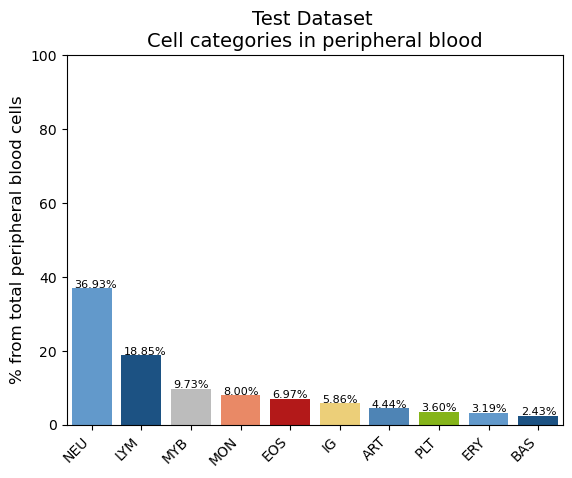

In [34]:
### Barplot : Cell categories for test dataset (wo images outliers)
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = test_data['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.sort_values(ascending=False)
sns.barplot(x=df_temp.index, y=df_temp.values, palette= colors)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.ylabel('% from total peripheral blood cells', fontsize =12)
plt.title("Test Dataset \nCell categories in peripheral blood", fontsize= 14)
for i in range(len(df_temp)):
    plt.text(x = i-0.35, y = df_temp.values[i]+0.2, s = f"{df_temp.values[i]:.2f}%", size = 8)

plt.savefig("barplot_cells_wo_10cat_test.png", dpi=300, bbox_inches='tight')

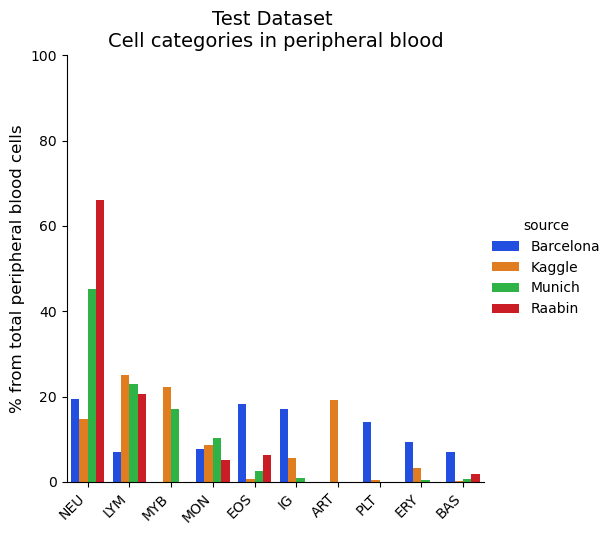

In [35]:
### Barplot : Cell categories for the whole dataset (wo images outliers) by training/val/test data
colors =['#509add', '#0b5394', '#bcbcbc', '#ff7f50', '#cc0000','#ffd966', '#3d85c6', '#8fce00']
df_temp = test_data.groupby('source')['blood_cell'].value_counts(normalize=True) * 100
df_temp = df_temp.reset_index(name='%')

order = ['NEU', 'LYM', 'MYB', 'MON', 'EOS', 'IG', 'ART', 'PLT', 'ERY', 'BAS']
sns.catplot(x='blood_cell', y='%', hue='source', data=df_temp, kind='bar', palette='bright', order=order)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100) # définir la limite supérieure de l'axe des y à 100
plt.xlabel('')
#plt.legend(loc='upper right',)
plt.ylabel('% from total peripheral blood cells', fontsize=12)
plt.title("Test Dataset \nCell categories in peripheral blood", fontsize=14)
plt.savefig("barplot_cells_wo_10cat_bysource_test.png", dpi=300, bbox_inches='tight')

### Quelques stat pour la répartition des classes du set d'entraînement et de test

In [36]:
# Tableau croisé pour train
crosstabl_train = pd.crosstab(index=train_data['blood_cell'], columns=train_data['source'])
pourcentages = crosstabl_train.apply(lambda x: 100 * x / float(x.sum()), axis=1)
crosstabl_train['Total'] = crosstabl_train.sum(axis=1)
crosstabl_train['% Total'] = 100 * crosstabl_train['Total'] / crosstabl_train['Total'].sum()
for col in crosstabl_train.columns[:-2]:
    crosstabl_train[col + ' %'] = 100 * crosstabl_train[col] / crosstabl_train['Total']
print(crosstabl_train)
# Tableau croisé pour validation
crosstabl_val = pd.crosstab(index=validation_data['blood_cell'], columns=validation_data['source'])
pourcentages = crosstabl_val.apply(lambda x: 100 * x / float(x.sum()), axis=1)
crosstabl_val['Total'] = crosstabl_val.sum(axis=1)
crosstabl_val['% Total'] = 100 * crosstabl_val['Total'] / crosstabl_val['Total'].sum()
for col in crosstabl_val.columns[:-2]:
    crosstabl_val[col + ' %'] = 100 * crosstabl_val[col] / crosstabl_val['Total']
print(crosstabl_val)
# Tableau croisé pour test
crosstabl_test = pd.crosstab(index=test_data['blood_cell'], columns=test_data['source'])
pourcentages = crosstabl_test.apply(lambda x: 100 * x / float(x.sum()), axis=1)
crosstabl_test['Total'] = crosstabl_val.sum(axis=1)
crosstabl_test['% Total'] = 100 * crosstabl_test['Total'] / crosstabl_test['Total'].sum()
for col in crosstabl_test.columns[:-2]:
    crosstabl_test[col + ' %'] = 100 * crosstabl_test[col] / crosstabl_test['Total']
print(crosstabl_test)

source      Barcelona  Kaggle  Munich  Raabin  Total    % Total  Barcelona %  \
blood_cell                                                                     
ART                 0    1914      11       0   1925   4.448501     0.000000   
BAS               784      43      43     179   1049   2.424144    74.737846   
EOS              1994      74     262     684   3014   6.965082    66.157930   
ERY               993     339      47       0   1379   3.186745    72.008702   
IG               1842     607      86       0   2535   5.858156    72.662722   
LYM               788    2558    2518    2292   8156  18.847780     9.661599   
MON               929     884    1156     494   3463   8.002681    26.826451   
MYB                 0    2146    2065       0   4211   9.731241     0.000000   
NEU              2133    1452    5532    6865  15982  36.932961    13.346265   
PLT              1498      61       0       0   1559   3.602708    96.087235   

source       Kaggle %   Munich %   Raab

In [40]:
# Tableau croisé pour train
crosstabl_train = pd.crosstab(index=train_data['blood_cell'], columns='source')
crosstabl_train['pourcentage'] = 100 * crosstabl_train / crosstabl_train.sum()
print(crosstabl_train)
# Tableau croisé pour val
crosstabl_val = pd.crosstab(index=validation_data['blood_cell'], columns='source')
crosstabl_val['pourcentage'] = 100 * crosstabl_val / crosstabl_val.sum()
print(crosstabl_val)
# Tableau croisé pour test
crosstabl_test = pd.crosstab(index=test_data['blood_cell'], columns='source')
crosstabl_test['pourcentage'] = 100 * crosstabl_test / crosstabl_test.sum()
print(crosstabl_test)

col_0       source  pourcentage
blood_cell                     
ART           1925     4.448501
BAS           1049     2.424144
EOS           3014     6.965082
ERY           1379     3.186745
IG            2535     5.858156
LYM           8156    18.847780
MON           3463     8.002681
MYB           4211     9.731241
NEU          15982    36.932961
PLT           1559     3.602708
col_0       source  pourcentage
blood_cell                     
ART            481     4.445882
BAS            262     2.421666
EOS            754     6.969221
ERY            345     3.188834
IG             634     5.860061
LYM           2039    18.846474
MON            866     8.004437
MYB           1053     9.732877
NEU           3995    36.925779
PLT            390     3.604769
col_0       source  pourcentage
blood_cell                     
ART            601     4.443951
BAS            328     2.425318
EOS            942     6.965395
ERY            431     3.186927
IG             793     5.863650
LYM     